# `dPdI.ipynb`

Procedure/notes/code for conversion from current noise A^2/Hz to power W^2/Hz following `QETpy` procedures

In [65]:
ajs_laptop = True # running code on AJ's laptop

# base location of "B13_Runs" folder
if ajs_laptop:
    folder_base = '/Volumes/B13Cryolab_Share'
else:
    folder_base = 'D:'

import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import os
import picoscopedata
import scipy.special as ss
import scipy.optimize as so
import scipy.integrate as si
import scipy.stats as st
import importlib
import pickle

import warnings
warnings.filterwarnings('ignore')
warnings.simplefilter('ignore')

# custom modules
import sys
if ajs_laptop:
    sys.path.append('../QETpy')
    sys.path.append('../optimal_filter')
else:
    sys.path.append('../../Documents/QETpy')
    sys.path.append('../../Documents/optimal_filter')
import qetpy as qp
import optimal_filter_utils as of


In [66]:
def to_ADC(x, config = None):
    if config and 'gain' in config:
        Gdigital = config['gain']
    else:
        Gdigital = 50
    Gsquid = 10 # squid gain (10 loops)
    Rfdbck = 1.2e3 # feedback resistor
    return x/(Rfdbck*Gsquid*Gdigital)

def to_ibias(x):
    return x/1.2e3

In [67]:
importlib.reload(picoscopedata)
#pd.read_csv('./ibis_data/20240924-0001_3.csv', skiprows=(1,2))

ibis = picoscopedata.PicoscopeData('20240924-0001', data_dir = './ibis_data', idx = range(1,4))

#ibis('H').shape, ibis.ts.shape

ts_untouched = picoscopedata.PicoscopeData('20240924-0001', data_dir = './ibis_data', idx = range(1,4), shift_times = False).ts


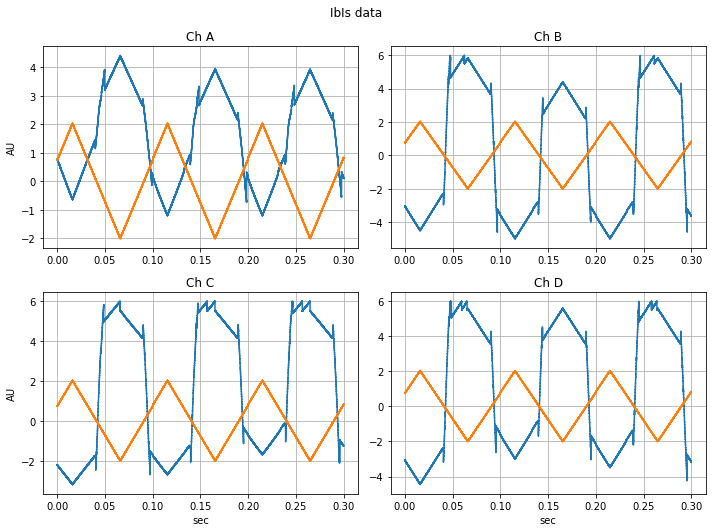

In [68]:
# plot IBIS data

fig, axs = plt.subplots(nrows = 2, ncols = 2, figsize = (10,7.5))

fig.suptitle('IbIs data')

for ax in axs[1]:
    ax.set_xlabel('sec')
for ax in axs[:,0]:
    ax.set_ylabel('AU')

for i, c, ax in zip(range(4), 'ABCD', axs.flatten()):

    ax.grid()

    ax.plot(ibis.ts, ibis(c))
    ax.plot(ibis.ts, ibis('H'))
    ax.set_title(f'Ch {c}')

fig.tight_layout()


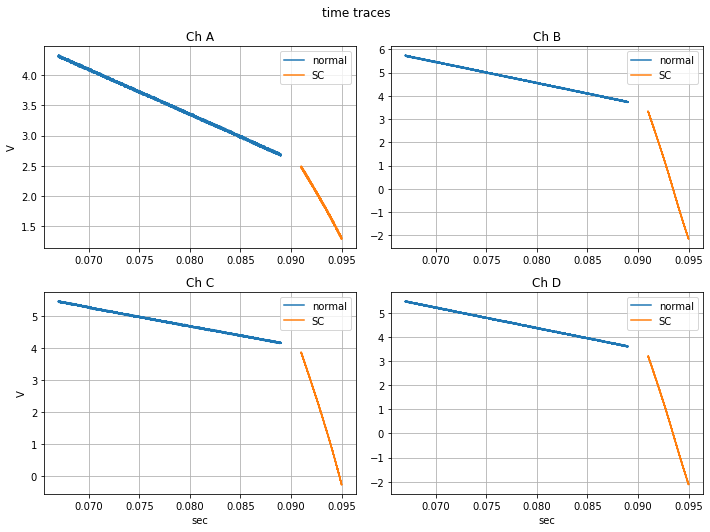

In [69]:
# normal/SC limits on IBIS data
n_lims = np.array([67_000, 89_000])
sc_lims = np.array([91_000, 95_000])
all_lims = np.hstack((n_lims, sc_lims))

normalinds = range(*n_lims)
scinds = range(*sc_lims)
full_sweep = range(all_lims.min(), all_lims.max())

fig, axs = plt.subplots(nrows = 2, ncols = 2, figsize = (10,7.5))

fig.suptitle('time traces')

for ax in axs[1]:
    ax.set_xlabel('sec')
for ax in axs[:,0]:
    ax.set_ylabel('V')

for i, c, ax in zip(range(4), 'ABCD', axs.flatten()):

    ax.grid()
    ax.set_title(f'Ch {c}')


    ax.plot(ibis.ts[normalinds], ibis(c)[normalinds], label = 'normal')
    ax.plot(ibis.ts[scinds], ibis(c)[scinds], label = 'SC')

    ax.legend()

    #ax.plot(ibis(c)[nslice])
    #ax.plot(ibis(c)[scslice])


    wind = ax.axis()

    #ax.plot(ibis.ts, ibis(c))

    ax.axis(wind)
    

fig.tight_layout()


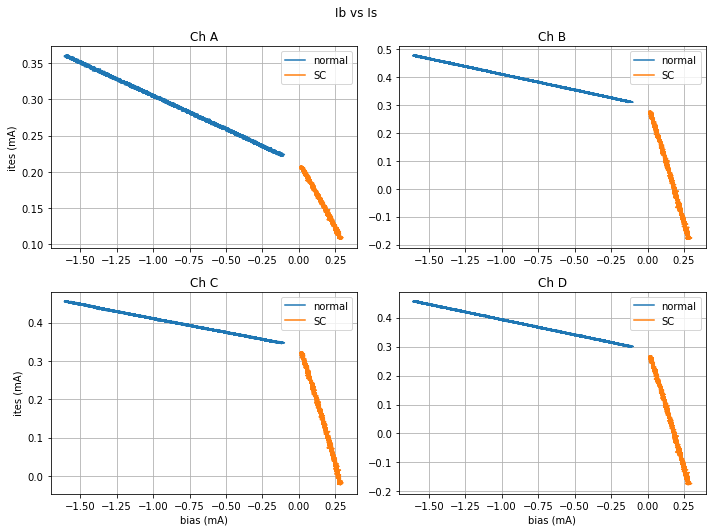

In [70]:
# normal/SC limits on IBIS data

fig, axs = plt.subplots(nrows = 2, ncols = 2, figsize = (10,7.5))

fig.suptitle('Ib vs Is')

for ax in axs[1]:
    ax.set_xlabel('bias (mA)')
for ax in axs[:,0]:
    ax.set_ylabel('ites (mA)')

for i, c, ax in zip(range(4), 'ABCD', axs.flatten()):

    ax.grid()
    ax.set_title(f'Ch {c}')


    ax.plot(to_ibias(ibis('H')[normalinds])*1e3, 1e3*to_ADC(ibis(c)[normalinds], ibis.config), label = 'normal')
    ax.plot(to_ibias(ibis('H')[scinds])*1e3, 1e3*to_ADC(ibis(c)[scinds], ibis.config), label = 'SC')

    ax.legend()

    #ax.plot(ibis(c)[nslice])
    #ax.plot(ibis(c)[scslice])


    wind = ax.axis()

    #ax.plot(ibis.ts, ibis(c))

    ax.axis(wind)
    

fig.tight_layout()


In [71]:
channels = 'ABCD'

pscope_digitizer_err = 0.01#20/(2**12)

ibias = np.stack(4*[to_ibias(ibis('H'))])[np.newaxis,:] # A

dites = np.array([-to_ADC(ibis(c), ibis.config) for c in channels])[np.newaxis,:] # A

ivfits = qp.IBIS(
    dites = dites, 
    ibias = ibias, 
    rsh = ibis.config['rsh'], 
    rsh_err = ibis.config['rsh']/100, 
    normalinds = normalinds, 
    scinds = scinds, 
    fitsc = True,
    chan_names = list(channels),
    dites_err = np.full(ibias.shape, pscope_digitizer_err),
    ibias_err = np.full(ibias.shape, pscope_digitizer_err),
    )

ivfits.analyze()

In [72]:
ivfits.rnorm # normal state resistances (Ohms)

array([[0.16171825, 0.16643119, 0.2581448 , 0.17818628]])

In [73]:
ivfits.rp # parasitic resistances (Ohms)

array([[ 0.03499064, -0.00836245, -0.00418476, -0.00795998]])

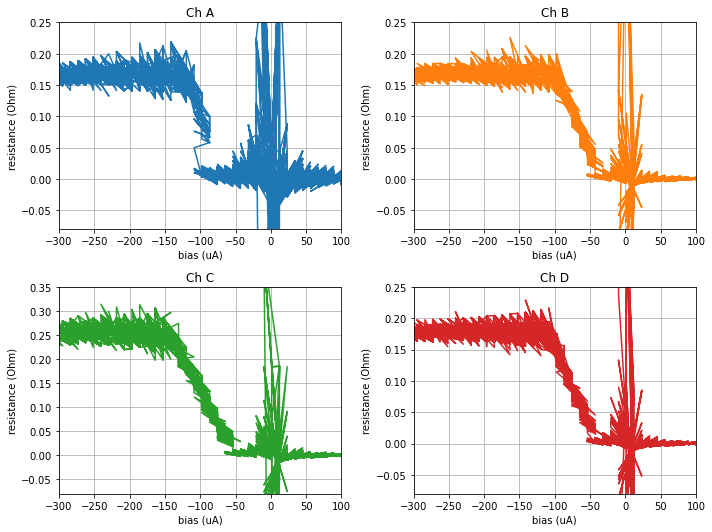

In [74]:
fig, axs = plt.subplots(nrows = 2, ncols = 2, figsize = (10,7.5))

for i, (c,ax) in enumerate(zip(channels, axs.flatten())):
    ax.grid()
    ax.set_title(f'Ch {c}')
    ax.plot(ibis('H')[full_sweep]*1e3, ivfits.r0[0,i][full_sweep], label = c, color = f'C{i}')
    ax.set_ylim(-0.08, 0.35 if c == 'C' else 0.25)
    ax.set_xlim(-300, 100)
    ax.set_xlabel('bias (uA)')
    ax.set_ylabel('resistance (Ohm)')

#plt.legend(loc = 'best')
fig.tight_layout()

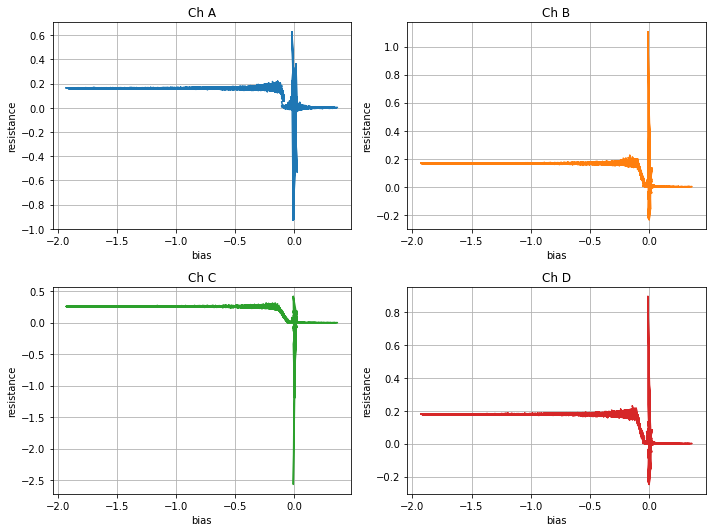

In [75]:
fig, axs = plt.subplots(nrows = 2, ncols = 2, figsize = (10,7.5))

for i, (c,ax) in enumerate(zip(channels, axs.flatten())):
    ax.grid()
    ax.set_title(f'Ch {c}')
    ax.plot(ibis('H')[full_sweep], ivfits.r0[0,i][full_sweep], label = c, color = f'C{i}')
    #ax.set_ylim(-0.1, 0.1)
    ax.set_xlabel('bias')
    ax.set_ylabel('resistance')

#plt.legend(loc = 'best')
fig.tight_layout()

In [76]:
ivfits.rnorm

array([[0.16171825, 0.16643119, 0.2581448 , 0.17818628]])

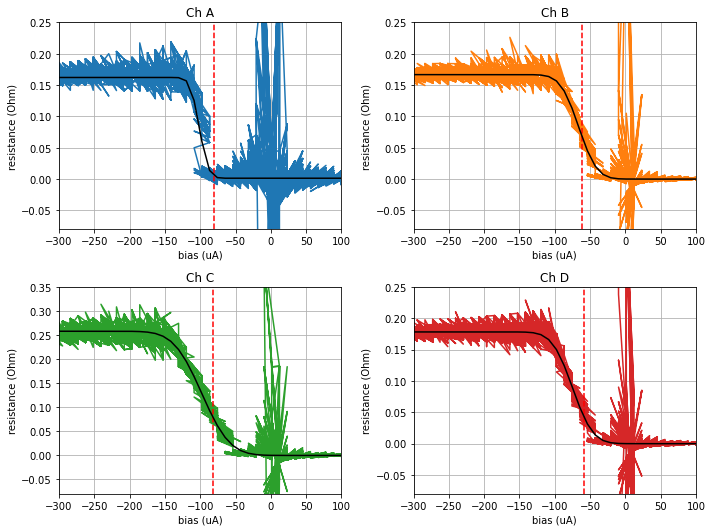

In [77]:
noise_windows = { # uA
    'A': (-40, 40),
    'B': (-25, 25),
    'C': (-30, 25),
    'D': (-35, 25)
}




#sweep_without_window = np.array([i in full_sweep for i in range(ibis.ts.size)])*(~window)

def transition_curve(x,  Rn, Rsc, loc, scale,):

    return Rsc + (Rn - Rsc)*ss.erfc((x - loc)/scale)/2

fig, axs = plt.subplots(nrows = 2, ncols = 2, figsize = (10,7.5))

popt = {}
pcov = {}

op_pts = (80.6, 62.0, 82.5, 58.1)

for i, (c,ax) in enumerate(zip(channels, axs.flatten())):
    ax.grid()
    ax.set_title(f'Ch {c}')


    x = ibis('H')[full_sweep]*1e3
    y = ivfits.r0[0,i][full_sweep]

    window = (x > noise_windows[c][0])*(x < noise_windows[c][1])

    xfit = x[~window]
    yfit = y[~window]


    popt[c], pcov[c] = so.curve_fit(transition_curve, xfit, yfit, p0 = (ivfits.rnorm[0,i], 0, -80, 20))

    y_opt = transition_curve(sorted(x), *popt[c])

    ax.plot(x, y, label = c, color = f'C{i}')
    #ax.plot(xfit, yfit, color = 'grey')
    ax.axvline(-op_pts[i], color = 'r', linestyle = 'dashed')
    ax.plot(sorted(x), y_opt, color = 'k')
    ax.set_ylim(-0.08, 0.35 if c == 'C' else 0.25)
    ax.set_xlim(-300, 100)
    ax.set_xlabel('bias (uA)')
    ax.set_ylabel('resistance (Ohm)')

#plt.legend(loc = 'best')
fig.tight_layout()

In [78]:
transition_fits = pd.DataFrame.from_dict(popt)
transition_fits.index = ('Rn', 'Rsc', 'loc', 'scale')

transition_fits

,A,B,C,D
Rn,0.162115,0.166671,0.258008,0.178289
Rsc,0.001350,-0.000033,-0.000257,-0.000023
loc,-101.123229,-66.186471,-97.805463,-74.881282
scale,14.315088,28.731211,44.312913,32.090586


In [125]:
dIb90_10 = [(ss.erfcinv(2*0.1) - ss.erfcinv(2*0.9))*transition_fits[c]['scale'] for c in 'ABCD']
dIb90_10 # transition width from 10% of normal to 90% of normal

[25.944487322632018, 52.07209139403966, 80.31217467256887, 58.160580672945386]

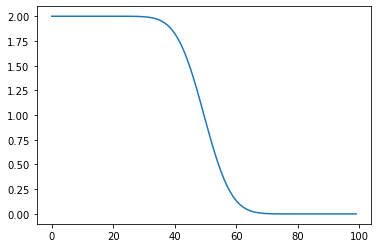

In [116]:
plt.plot(ss.erfc(np.linspace(-5, 5, 100)))

In [79]:
ivfits.rnorm

array([[0.16171825, 0.16643119, 0.2581448 , 0.17818628]])

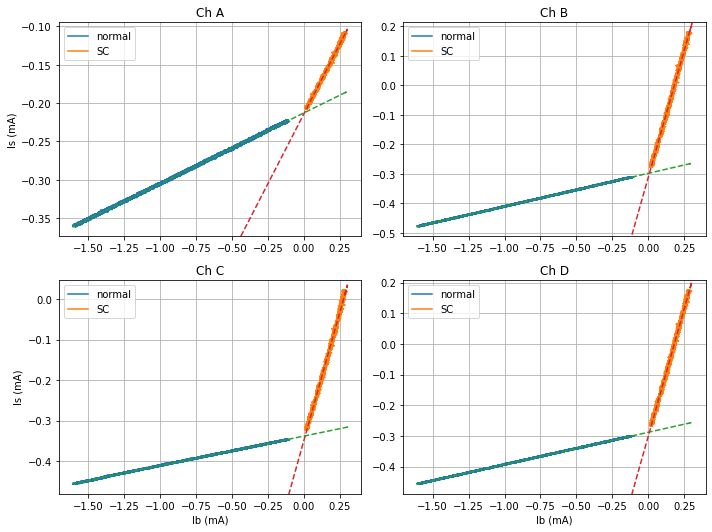

In [80]:

fig, axs = plt.subplots(nrows = 2, ncols = 2, figsize = (10,7.5))

for ax in axs[1]:
    ax.set_xlabel('Ib (mA)')
for ax in axs[:,0]:
    ax.set_ylabel('Is (mA)')

for i, c, ax in zip(range(4), 'ABCD', axs.flatten()):

    ax.grid()
    ax.set_title(f'Ch {c}')


    ax.plot(1e3*to_ibias(ibis('H')[normalinds]), -1e3*to_ADC(ibis(c)[normalinds], ibis.config), label = 'normal')
    ax.plot(1e3*to_ibias(ibis('H')[scinds]), -1e3*to_ADC(ibis(c)[scinds], ibis.config), label = 'SC')

    wind = ax.axis()

    ax.legend()

    xplot = to_ibias(ibis('H')[full_sweep])

    norm_fit = lambda x: ivfits.int_n[0,i,0] + ivfits.slope_n[0,i,0]*x
    sc_fit = lambda x: ivfits.int_sc[0,i,0] + ivfits.slope_sc[0,i,0]*x

    ax.plot(1e3*xplot, 1e3*norm_fit(xplot), '--')
    ax.plot(1e3*xplot, 1e3*sc_fit(xplot), '--')


    ax.axis(wind)

    #ax.plot(ibis(c)[nslice])
    #ax.plot(ibis(c)[scslice])


    wind = ax.axis()

    #ax.plot(ibis.ts, ibis(c))

    ax.axis(wind)
    

fig.tight_layout()


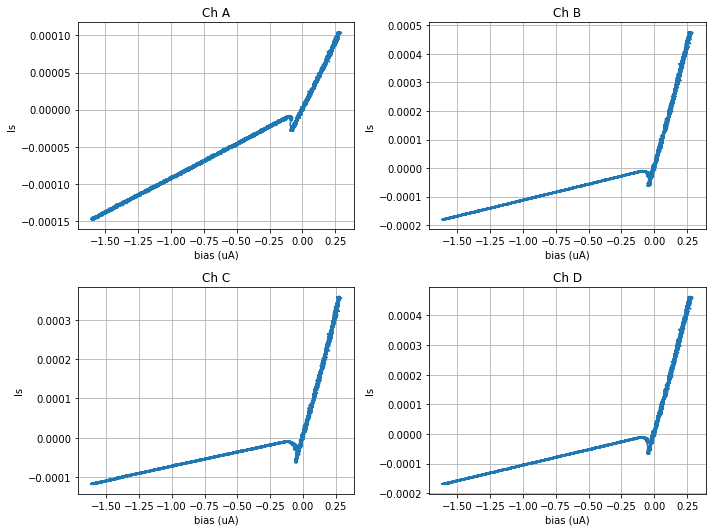

In [81]:

fig, axs = plt.subplots(nrows = 2, ncols = 2, figsize = (10,7.5))


for i, c, ax in zip(range(4), 'ABCD', axs.flatten()):

    ax.grid()
    ax.set_title(f'Ch {c}')
    ax.set_xlabel('bias (uA)')
    ax.set_ylabel('Is')


    #ax.plot(ibis('H')[normalinds], -ibis(c)[normalinds], label = 'normal')
    #ax.plot(ibis('H')[scinds], -ibis(c)[scinds], label = 'SC')
    ax.plot(ivfits.ibias_true[0,i][full_sweep]*1e3, ivfits.ites[0,i][full_sweep])

    wind = ax.axis()

    #ax.legend()

    #ax.plot(ibis('H')[full_sweep], ivfits.int_n[0,i,0] + ivfits.slope_n[0,i,0]*ibis('H')[full_sweep], '--')
    #ax.plot(ibis('H')[full_sweep], ivfits.int_sc[0,i,0] + ivfits.slope_sc[0,i,0]*ibis('H')[full_sweep], '--')


    ax.axis(wind)

    #ax.plot(ibis(c)[nslice])
    #ax.plot(ibis(c)[scslice])


    wind = ax.axis()

    #ax.plot(ibis.ts, ibis(c))

    ax.axis(wind)
    

fig.tight_layout()


In [82]:
importlib.reload(picoscopedata)

<module 'picoscopedata' from '/Users/ajbiffl/Documents/CDMS/tes_noise/picoscopedata.py'>

In [83]:
# config dict
drive_path = folder_base + '/B13_Runs/Run94/AJ/dIdV/20240925-0001'

didv = picoscopedata.PicoscopeData('20240925-0001', drive_path, idx = range(1,335), vertical_stack = True)
#didv1 = picoscopedata.PicoscopeData('20240924-0001', './didv_data', 1, shift_times = False)

# __didv_config = {
#     'series_name': 'test_fakedata_1',
#     'group_name': 'fakes',
#     'fs': (1/np.diff(didv.ts)).mean(), # sample rate (Hz)
#     'output_variable_gain': 50., # output gain
#     #'output_variable_offset': 0., # voltage offset (so, DC component I think?) (V)
#     #'close_loop_norm': 625_000., # idk
#     'rshunt': didv.config['rsh'], # shunt resistance (Ohms)
#     #'rp': 0.001, # estimated parasitic resistance of non-shunt side of TES circuit (Ohms)
#     #'tes_bias': 0.000005, # bias?
#     'sgfreq': 500., # frequency of signal generator (Hz)
#     'sgamp': 0.5e-3, # peak-to-peak size of square wave from signal generator (A)
# }

# __didv_config = pd.Series(__didv_config)

# __didv_config

In [84]:
R_ops = np.array([transition_curve(-didv.config['off'+c], *popt[c]) for c in 'ABCD'])
#R_ops = np.array([transition_curve(-R, *popt[c]) for c, R in zip('ABCD', (80.6, 62.0, 82.5, 58.1))]) 

R_ops*1e3 # milliohms

array([ 4.77510132, 69.7107602 , 80.47961433, 40.95121805])

In [85]:
# normal mode resistances (also milliohms)
ivfits.rnorm*1e3

array([[161.71825174, 166.4311851 , 258.14479619, 178.18628135]])

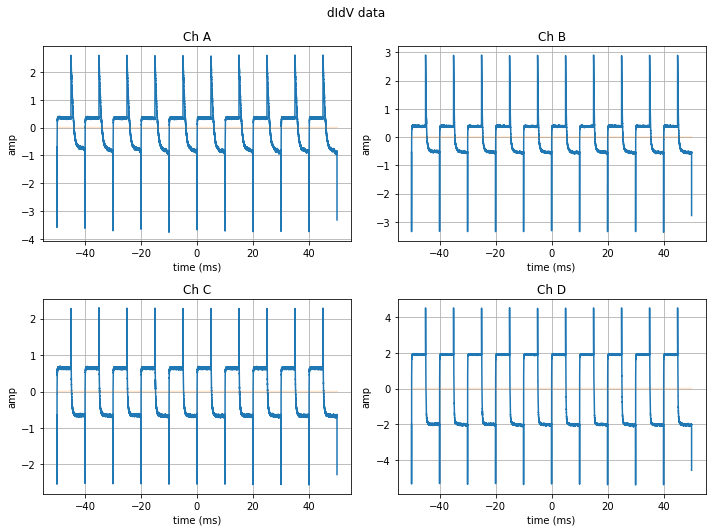

In [86]:
# plot DIDV data

didv_waveform = didv('H')[0]

fig, axs = plt.subplots(nrows = 2, ncols = 2, figsize = (10,7.5))

fig.suptitle('dIdV data')


for i, c, ax in zip(range(4), 'ABCD', axs.flatten()):

    ax.grid()
    ax.set_ylabel('amp')
    ax.set_xlabel('time (ms)')
    ax.set_title(f'Ch {c}')

    ax.plot(didv.ts*1e3, didv(c)[0])
    ax.plot(didv.ts*1e3, didv('H')[0]/10, alpha = 0.2)
    #ax.plot(didv1.ts*1e3, didv1(c))

fig.tight_layout()


In [87]:
np.round(1/(np.diff(didv.ts)).mean())

1000000.0

In [88]:
ivfits.r0[0,2][normalinds].mean()

0.2578238355519627

In [89]:
ff = np.round(1/((np.diff(didv.ts)).mean()))
freq = 100

ff, freq, ff/freq, didv.ts.size/10

(1000000.0, 100, 10000.0, 10000.4)

In [90]:
didv.config

{'amp': 0.02,
 'freq': 100.0,
 'offA': 80.6,
 'offB': 62.0,
 'offC': 82.5,
 'offD': 58.1,
 'gain': 50.0,
 'rsh': 0.02}

In [91]:
didvfit = {}

for i, c in enumerate('ABCD'):
    didvfit[c] = qp.DIDV(
        rawtraces = to_ADC(didv(c), didv.config),
        fs = np.round(1/((np.diff(didv.ts)).mean())),
        sgfreq = didv.config['freq'],
        sgamp = to_ibias(didv.config['amp']),
        rsh = didv.config['rsh'],
        rp = ivfits.rp[0,i],
        dutycycle = 0.5,
        add180phase = False,
        #autoresample = True,
        r0 = R_ops[i], # estimated TES resistance (Ohms)
        tracegain = 1,#(didv.config['gain'])*(10)*(1.2e3), # what to divide by to convert rawtraces to Amps (from convert_ADC)
        dt0 = 1.5e-6 # guess
        )

    didvfit[c].processtraces()

In [92]:
# fit 
for c in 'ABCD':
    didvfit[c].dofit(2) # Two poles fit
    didvfit[c].dofit(3) # Tree poles fit



In [93]:
for c in 'ABCD':
    for p in (2,3):
        print(c, ',', p, 'pole:', didvfit[c].fitresult()[p]['params']['dt'])

A , 2 pole: 1.5597803104490393e-06
A , 3 pole: 1.5682038991217906e-06
B , 2 pole: 1.6267257262155707e-06
B , 3 pole: 1.653449356339357e-06
C , 2 pole: 1.4637097313974699e-06
C , 3 pole: 1.4354978197716967e-06
D , 2 pole: 1.7196766776229375e-06
D , 3 pole: 1.6726332351220698e-06


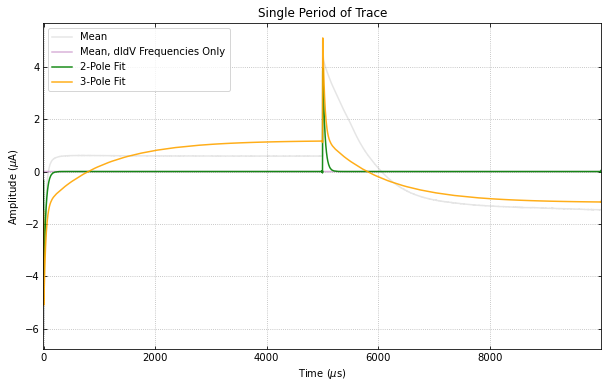

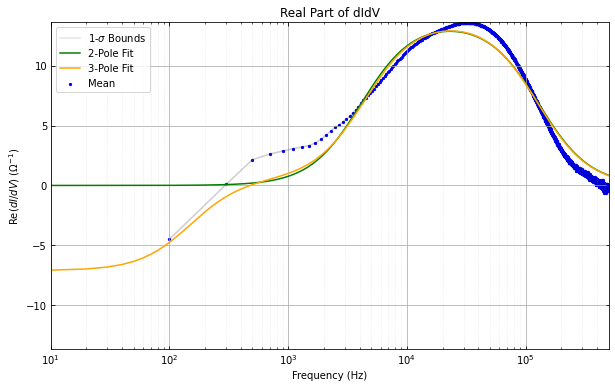

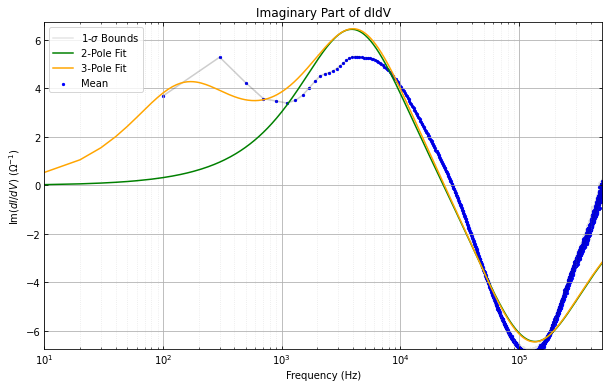

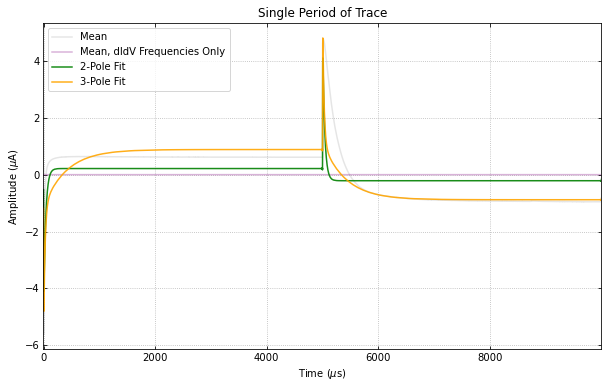

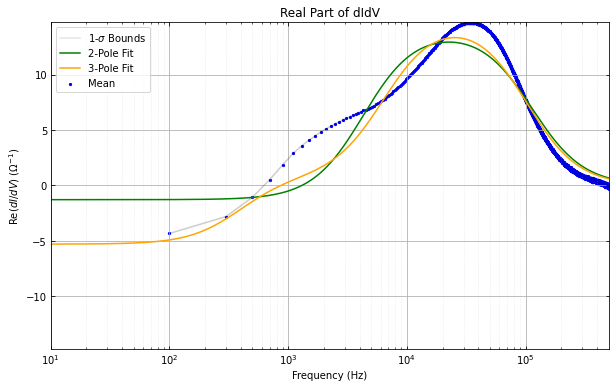

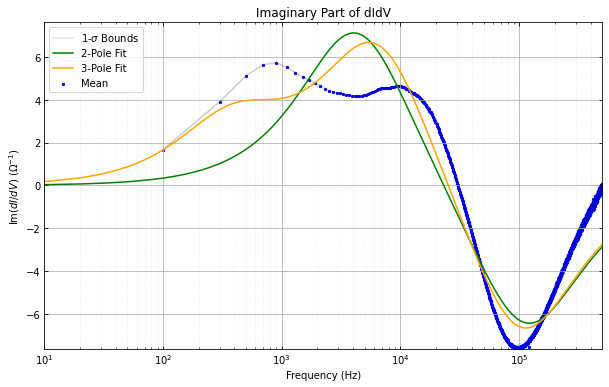

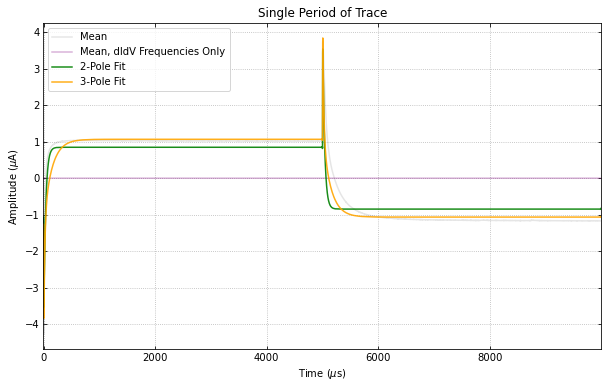

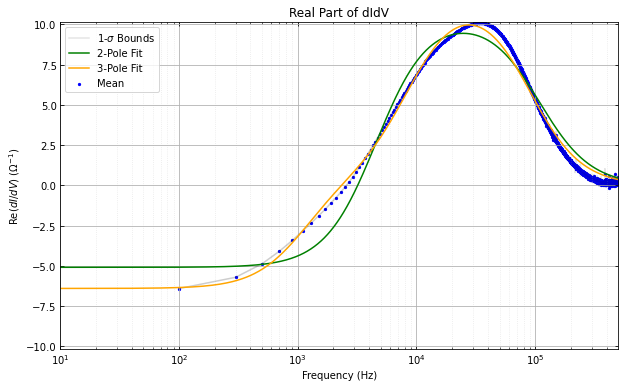

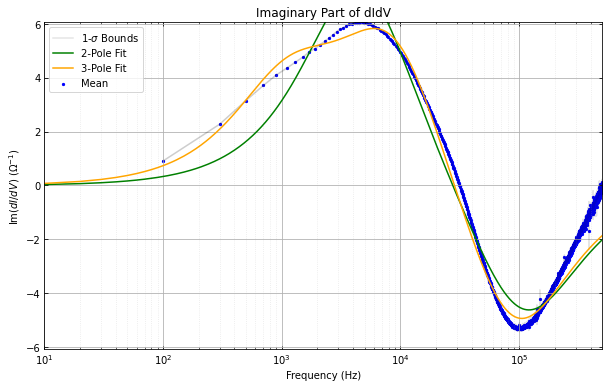

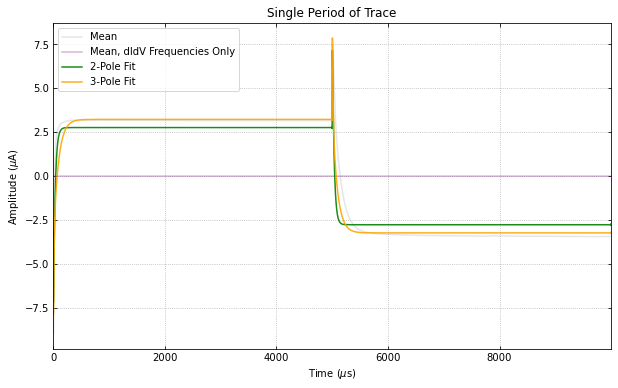

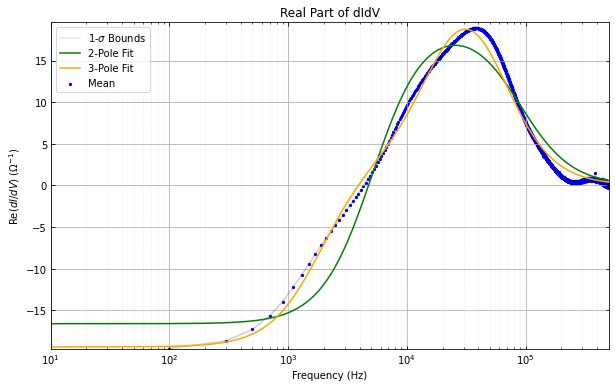

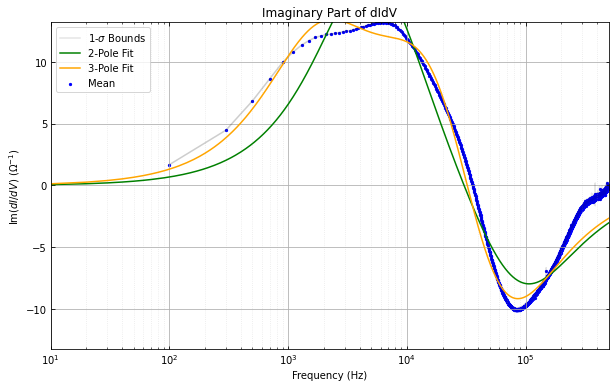

In [94]:
# display
for c in 'ABCD':
    didvfit[c].plot_single_period_of_trace(didv_freq_filt=True)
    didvfit[c].plot_re_im_didv()

In [95]:
# IBIS object can take multiple bias points (iters), channels (chs), and different temperatures (temps)
# input array dites has shape either (niters,), (nch,niters), or (ntemps,nch,niters)
# bias vals given in ibias (should be increasing along "iters" dimension)

# read dites/ibias data from csv
#ivdf = pd.read_csv('IV.csv', index_col = 0)

#chan_names = list(ivdf.columns)
#ibias = np.expand_dims(np.stack(len(chan_names)*[ivdf.index.values]), axis = 0)
#ibias = np.stack(len(chan_names)*[ivdf.index.values], axis = 0)[np.newaxis,:]
#dites = np.array([ivdf[c].values for c in chan_names])[np.newaxis,:]

# create IBIS object
#ivdata = qp.IBIS(
#    dites = dites, # read out current from electronics (A)
#    dites_err = np.zeros(dites.shape), 
#    ibias = ibias, # TES bias current for dites measurements (A)
#    ibias_err = np.zeros(ibias.shape),
#    rsh = didv.config['rsh'], # shunt resistance of TES circuit
#    rsh_err = 0.,
#    normalinds = np.array([0,1,2]), # indices of normal resistance points in dites (will do separate normal and SC fits)
#    #rp_guess = ,
#    #rp_err_guess = ,
#    chan_names = chan_names
#)

#ivdata.analyze()
# then e.g. grab ivdata.r0 for r0 in dict below

# IBIS objects fit (Ib,Is) data (aka (ibias/dites)) to lines of the form
# Is = A*Ib + B

# ivdata.rp = parasitic resistance in TES line
# ivdata.rnorm = normal-state resistance of TES
# ivdata.rfit = total resistance rnorm + rp + Rs
# ivdata.r0 = equiv to rnorm, but accounting for shift of the "baseline" point of the normal-mode Ib/Is line (so looking at (dites - ioff) = (rsh/(rsh+rp+r0))(ibias - ibias_off) ) '
# ---> (Is - Is0) = (Rs/(Rs+Rp+Rn))(Ib - Ib0)
# ivdata.ioff = TES current offset - point where SC and normal mode lines intersect (y-coord)
# ivdata.ibias_off = bias current offset - point where SC and normal mode lines intersect (x-coord)
# ites = dites - ioff
# ibias_true = ibias - ibias_off

In [96]:
# condense info from IbIs (and other sources) into dict
# (this dict from didv demo notebook)


# "required params" ['rp', 'i0', 'i0_err','r0', 'r0_err']

In [97]:
# ibis notes:
# triangle wave
# 0.1 Hz
# 2 V
# set QET biases to zero
# gain 1

# didv notes:
# square wave
# 100 Hz
# 20 mV
# gain 50

# offx - QET bias in V

In [98]:
ivfits.rp[0]
#didv.config['offA']

array([ 0.03499064, -0.00836245, -0.00418476, -0.00795998])

In [99]:
# dict used to calculate small signal params
for i, c in enumerate('ABCD'):

    ivsweep_results_fromdemo = {
        'close_loop_norm': 10*1.2e3*2, # idk (see above)
        'group_name_sweep': 'iv_didv_I2_D20230923_T131239',
        'i0': didv.config['off'+c]/1e6, # ?? from Irwin chapter the "steady state" current given as I0 (A) (maybe ites?)
        # maybe baseline current outside of square wave amplitude?
        'i0_err': 0.,#8.342312444985714e-12,
        'i0_off': 0.,#3.89669341000469e-09, # ioff from DIDV? - the current offset (A)
        'i0_off_err': 0.,#5.507092047349402e-12,
        'i0_variable_offset': 0., #-9.865689873695374e-06, # ??
        'ibias': didv.config['off'+c]/1e6, # applied QET bias current (A) (ibias)
        'ibias_off': 0.,#-3.381406772500224e-08, # current offset of the QET bias (A)
        'ibias_off_err': 0.,#1.0347074588426951e-11,
        'lgc_invert_offset': True, 
        'output_variable_gain': 50.0, # see above
        'output_variable_offset': 0,#-0.12332112342119217, # see above
        'p0': 3.2911e-15, # power of TES (W)? (from bulk_tes_noise.ipynb)
        'p0_err': 5e-17,
        'r0': R_ops[i], # TES resistance (Ohms)?
        'r0_err': ivfits.rnorm_err[0,i], #0.003534606260879604,
        'rn': ivfits.rnorm[0,i], # normal-state resistance (Ohms) ?
        'rn_err': ivfits.rnorm_err[0,i], 
        'rp': ivfits.rp[0,i], # parasitic resistance in non-shunt side of TES circuit (see above) (Ohms)
        'rp_err': ivfits.rp_err[0,i],
        'rshunt': ibis.config['rsh'], # shunt resistance (Ohms)
        'rshunt_err': ibis.config['rsh']/100
        }

    ivsweep_results = {
        'rp': didvfit[c]._rp, #max((ivfits.rp[0,i], 0)), 
        'i0': didv.config['off'+c]/1e6, 
        'i0_err': didv.config['off'+c]/1e8,
        'r0': R_ops[i], 
        'r0_err': R_ops[i]/100
    }


    didvfit[c].calc_smallsignal_params(ivsweep_results)

INFO: Calculating small signal parameters for 2-poles model 
INFO: Calculating small signal parameters for 3-poles model 
INFO: Calculating small signal parameters for 2-poles model 
INFO: Calculating small signal parameters for 3-poles model 
INFO: Calculating small signal parameters for 2-poles model 
INFO: Calculating small signal parameters for 3-poles model 
INFO: Calculating small signal parameters for 2-poles model 
INFO: Calculating small signal parameters for 3-poles model 


In [100]:
didvfit['A'].fitresult(3).keys()

dict_keys(['lgcfix', 'params_array', 'params', 'cov', 'errors', 'falltimes', 'cost', 'offset', 'offset_err', 'biasparams', 'smallsignalparams', 'ssp_light', 'didv0', 'dpdi0', 'dpdi0_err'])

In [101]:
for c in 'ABCD':
        # printing out results
        results = didvfit[c].fitresult()
        data = {'Model':['2-pole', '3-pole'],
                'Tau1 [usec]': ['{:.3g}'.format(1e6*np.abs(results[2]['params']['tau1'])),
                                '{:.3g}'.format(1e6*np.abs(results[3]['params']['tau1']))],
                'Tau2 [usec]': ['{:.3g}'.format(1e6*results[2]['params']['tau2']),
                                '{:.3g}'.format(1e6*results[3]['params']['tau2'])],
                'Tau3 [usec]': ['{:.3g}'.format(1e6*results[2]['params']['tau3']),
                                '{:.3g}'.format(1e6*results[3]['params']['tau3'])]}
                
                
        
        # Create a DataFrame
        df = pd.DataFrame(data)

        # Display the DataFrame
        print('Fit time constants, NOT dIdV Poles: ')
        print(df.to_string(index = False))
                
        data = {'Model':['2-pole', '3-pole'],
                'Tau+[usec]': ['{:.3g}'.format(1e6*results[2]['falltimes'][0]),
                        '{:.3g}'.format(1e6*results[3]['falltimes'][0])],
                'Tau-[usec]': ['{:.3g}'.format(1e6*results[2]['falltimes'][1]),
                        '{:.3g}'.format(1e6*results[3]['falltimes'][1])],
                'Tau3[usec]': ['{:.3g}'.format(1e6*results[2]['falltimes'][2]),
                        '{:.3g}'.format(1e6*results[3]['falltimes'][2])]}
        # Create a DataFrame
        df = pd.DataFrame(data)

        # Display the DataFrame
        print('\nTrue dIdV Poles: ')
        print(df.to_string(index = False))

        print('\n============\n')

Fit time constants, NOT dIdV Poles: 
 Model Tau1 [usec] Tau2 [usec] Tau3 [usec]
2-pole    2.34e+05         1.2           0
3-pole    7.17e+09        1.22         669

True dIdV Poles: 
 Model Tau+[usec] Tau-[usec] Tau3[usec]
2-pole       1.24       38.6          0
3-pole       1.22        425        669


Fit time constants, NOT dIdV Poles: 
 Model Tau1 [usec] Tau2 [usec] Tau3 [usec]
2-pole         386        1.36           0
3-pole    4.66e+09        1.47         284

True dIdV Poles: 
 Model Tau+[usec] Tau-[usec] Tau3[usec]
2-pole       1.41       36.9          0
3-pole       1.57       24.7        408


Fit time constants, NOT dIdV Poles: 
 Model Tau1 [usec] Tau2 [usec] Tau3 [usec]
2-pole        67.1        1.39           0
3-pole         163        1.63        90.3

True dIdV Poles: 
 Model Tau+[usec] Tau-[usec] Tau3[usec]
2-pole       1.48       34.7          0
3-pole        1.8       18.1        142


Fit time constants, NOT dIdV Poles: 
 Model Tau1 [usec] Tau2 [usec] Tau3 [usec]

In [102]:
# functions to get physical params

In [103]:
didvfit['A'].fitresult(3)['smallsignalparams']

{'rsh': 0.02,
 'rp': 0.034990641871376515,
 'r0': 0.004775101317610458,
 'beta': 3.7220855122999232,
 'l': 1.000000001857036,
 'L': 9.451329748725053e-08,
 'tau0': 1.3308925298942175e-05,
 'gratio': 0.12518890387015533,
 'tau3': 0.0006692496313610531,
 'dt': 1.5682038991217906e-06}

In [104]:
signalparams = pd.DataFrame.from_dict({param: [didvfit[c].fitresult(3)['smallsignalparams'][param] for c in 'ABCD'] for param in ['rsh', 'rp', 'r0', 'beta', 'l', 'L', 'tau0', 'gratio', 'tau3', 'dt']})
signalparams.index = list('ABCD')
signalparams.T

,A,B,C,D
rsh,2.000000e-02,2.000000e-02,2.000000e-02,2.000000e-02
rp,3.499064e-02,-8.362453e-03,-4.184764e-03,-7.959984e-03
r0,4.775101e-03,6.971076e-02,8.047961e-02,4.095122e-02
beta,3.722086e+00,-9.070380e-02,6.321089e-02,4.371701e-02
l,1.000000e+00,1.000000e+00,1.236417e+00,1.254485e+00
L,9.451330e-08,1.106562e-07,1.653293e-07,1.173691e-07
tau0,1.330893e-05,4.771251e-05,3.855058e-05,2.130165e-05
gratio,1.251889e-01,5.042316e-01,5.603447e-01,7.328151e-01
tau3,6.692496e-04,2.841080e-04,9.025750e-05,4.313307e-05
dt,1.568204e-06,1.653449e-06,1.435498e-06,1.672633e-06


In [105]:
# calculate and plot dPdIs
if 0:
    for chan in 'ABCD':
        qp.get_dPdI_with_uncertainties(len(didv.ts)*didv.ts/4/(didv.ts[-1]-didv.ts[0])**2, didvfit[chan].fitresult()[3], lgcplot=True)

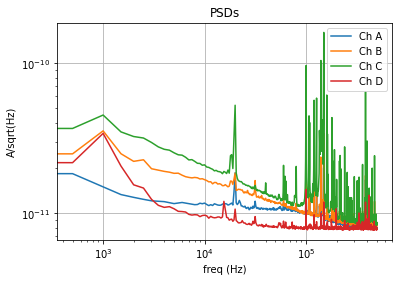

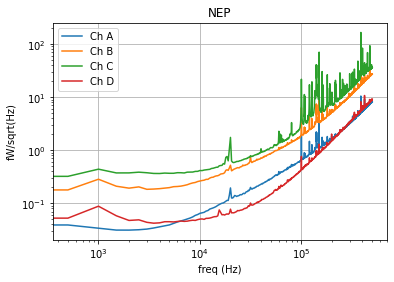

In [126]:
# calculate NEP from PSD data and write to txt files

psd_data_output_dir = folder_base + 'B13_Runs_LabVIEW/Run94/'

def read_PSD(filename, nsamples, trace_length):
    fs = nsamples/trace_length
    psd = np.loadtxt(filename)
    fs, _ = qp.utils.fold_spectrum(qp.utils.fft(np.zeros(2*psd.size-2), fs = fs)[0], fs = fs)
    return fs, psd

fig1, ax1 = plt.subplots(1,1)
ax1.set_title('PSDs')

fig2, ax2 = plt.subplots(1,1)
ax2.set_title('NEP')

psd_path = folder_base + '/B13_Runs_LabVIEW/Run94/Sapphire_ChABCD_SWT_weekend/Analysis 11/'


dpdi = {}

for chan in 'ABCD':
    fs, psd = read_PSD(psd_path + f'PSD/Ch {chan} PSD.txt', nsamples = 1000_000, trace_length = 1)
    dpdi[chan], dpdi_err = qp.get_dPdI_with_uncertainties(fs, didvfit[chan].fitresult()[3])

    #np.savetxt(psd_data_output_dir + f'Ch{chan}.txt', abs(dpdi[chan]))

    ax1.plot(fs, psd, label = f'Ch {chan}')
    ax2.plot(fs, 1e15*psd*abs(dpdi[chan]), label = f'Ch {chan}')


ax1.grid()
ax2.grid()
ax1.loglog()
ax2.loglog()
ax1.set_xlabel('freq (Hz)')
ax2.set_xlabel('freq (Hz)')
ax1.set_ylabel('A/sqrt(Hz)')
ax2.set_ylabel('fW/sqrt(Hz)')
ax1.legend()
ax2.legend()



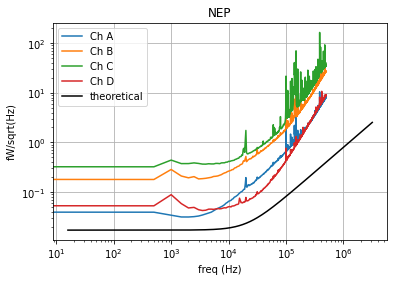

In [138]:
# compare to theoretical NEP spectrum from mpyle Ch 3

with open('Sp.txt', 'rb') as f:
    Sp, fn = pickle.load(f)


fig2, ax2 = plt.subplots(1,1)
ax2.set_title('NEP')

for chan in 'ABCD':
    fs, psd = read_PSD(psd_path + f'PSD/Ch {chan} PSD.txt', nsamples = 1000_000, trace_length = 1)

    ax2.plot(fs, 1e15*psd*abs(dpdi[chan]), label = f'Ch {chan}')

ax2.plot(fn, 1e15*np.sqrt(Sp), label = 'theoretical', color = 'k')


ax2.grid() 
ax2.loglog()
ax2.set_xlabel('freq (Hz)')
ax2.set_ylabel('fW/sqrt(Hz)')
ax2.legend()



In [128]:
dpdi['A'].shape, psd.shape

((1000,), (1000,))

In [129]:
# get pulse templates

templates_unnorm = {}
templates = {}

for c in 'ABCD':

    templates_unnorm[c] = np.loadtxt(psd_path + f'Templates 2/Ch {c} Template.txt')

    templates[c] = templates_unnorm[c]/templates_unnorm[c].max()

_, ts_template, ws_template = of.get_idx_tk_wn(templates['A'].size, 1e-3) # templates = 2 ms traces

fs_template = ws_template/2/np.pi # frequencies for template frequency space [Hz]

Text(0.5, 0, 'time (ms)')

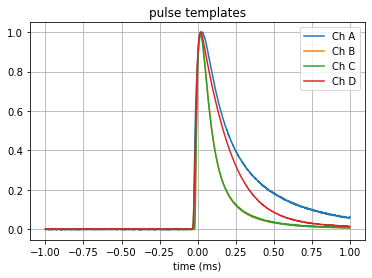

In [130]:
plt.figure()

for c in 'ABCD':
    plt.plot(ts_template*1e3, templates[c], label = f'Ch {c}')

#plt.axis((-0.2, 0.2, 0.5,1.1))
plt.title('pulse templates')
plt.grid()
plt.legend()
plt.xlabel('time (ms)')

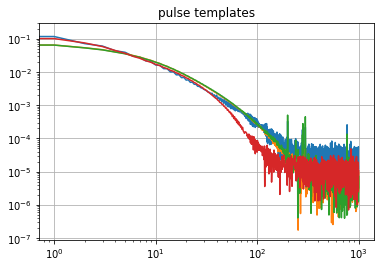

In [131]:
plt.figure()

for c in 'ABCD':
    plt.plot(abs(of.fft(templates[c])[:templates[c].size//2]), label = f'Ch {c}')

plt.loglog()
#plt.axis((-0.2, 0.2, 0.5,1.1))
plt.title('pulse templates')
plt.grid()

In [132]:
# convert templates to frequency domain and convert to power
pulse_power = {}

template_energy = {} # energy (keV) of template

edge_cut = 5

for c in 'ABCD':

    temp_w = of.fft(templates[c])

    #dpdi_unfolded = np.hstack((dpdi[c][::-1], dpdi[c]))/2
    dpdi_unfolded = np.hstack((abs(dpdi[c]), abs(dpdi[c])[::-1]))/2

    pow_w = temp_w*dpdi_unfolded

    pulse_power[c] = of.ifft(pow_w)

    template_energy[c] = np.trapz(np.real(pulse_power[c])[edge_cut:-edge_cut], ts_template[edge_cut:-edge_cut]) / 1.602e-16
    

Text(0.5, 0, 'time (ms)')

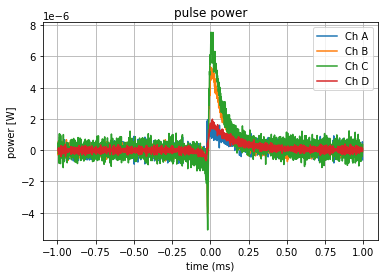

In [133]:
plt.figure()

for c in 'ABCD':
    plt.plot(ts_template[edge_cut:-edge_cut]*1e3, np.real(pulse_power[c][edge_cut:-edge_cut]), label = f'Ch {c}')

plt.title('pulse power')
plt.grid()
plt.legend()
plt.ylabel('power [W]')
plt.xlabel('time (ms)')

In [134]:
template_energy

{'A': 1375312.593796151,
 'B': 2708773.0865606815,
 'C': 3830259.6721297554,
 'D': 1752401.923068239}

In [135]:
# calculate phonon collection efficiency

# position of 6 keV peaks
peak_positions = {
    'A': None,
    'B': 1.78448e-7,
    'C': 8.97955e-8,
    'D': None
}

peak_energy = 6.

print('phonon collection efficiencies')
for c in 'ABCD':
    if peak_positions[c]:
        unit_energy = 6./peak_positions[c] # energy of pulse with unit height
        print(c, ':', f'{100*template_energy[c]/unit_energy:.5g} %')

phonon collection efficiencies
B : 8.0563 %
C : 5.7323 %


Text(0.5, 0, 'time (ms)')

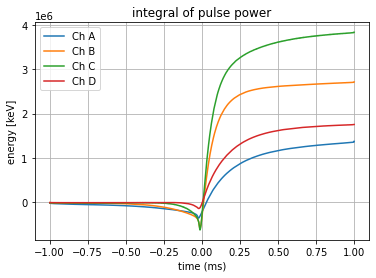

In [136]:
# cumulative energy
plt.figure()

for c in 'ABCD':
    plt.plot(1e3*ts_template[1:], si.cumulative_trapezoid(np.real(pulse_power[c])/1.6e-16, ts_template), label = f'Ch {c}')

plt.title('integral of pulse power')
plt.grid()
plt.legend()
plt.ylabel('energy [keV]')
plt.xlabel('time (ms)')

2.0176280701754385 5.359859649122825


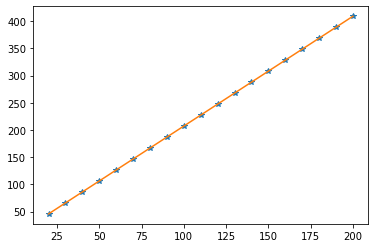

In [137]:
# output amplitude to picoscope measured amplitude
# mV
# uncertainties on measured amplitude ~1%
meas = np.array([
    [20, 45.78],
    [30, 66.2],
    [40, 85.9],
    [50, 106],
    [60, 127],
    [70, 146.5],
    [80, 166.5],
    [90, 187],
    [100, 207],
    [110, 227.4],
    [120, 247.3],
    [130, 267.2],
    [140, 287.7],
    [150, 308.1],
    [160, 328.1],
    [170, 348.6],
    [180, 368.5],
    [190, 389],
    [200, 408.9],
])

gains = meas[:,1]/meas[:,0]

Vin, Vout = meas.T
#print(gains.mean(), '+/-', gains.std())

pico_line = st.linregress(Vin, Vout)

print(pico_line.slope, pico_line.intercept)

plt.plot(Vin, Vout, '*')
plt.plot(Vin, pico_line.intercept + Vin*pico_line.slope)